# DeepFake Detection using CNN + Squeeze-and-Excitation Networks

## Project Overview

This project aims to build a machine learning model capable of detecting deepfake images using Convolutional Neural Networks (CNNs). The core idea behind this approach is to leverage the pre-trained **EfficientNet-B0** model, a state-of-the-art CNN architecture, to extract features from images. To enhance the model’s performance, we introduce a **Squeeze-and-Excitation (SE) block**, which dynamically recalibrates the channel-wise feature responses by learning the importance of each feature.

### **Key Steps:**
1. **Data Preprocessing:**
   - The images are resized to 256x256 pixels and converted to tensor format for processing.
   - The dataset is split into three sets: **Training**, **Validation**, and **Testing**. 

2. **Model Architecture:**
   - **EfficientNet-B0** is used as the backbone for feature extraction, which is pre-trained on ImageNet and fine-tuned for deepfake detection.
   - The **Squeeze-and-Excitation block** (SE Block) is added to the network to recalibrate the feature maps by learning the importance of each channel.
   - A **Fully Connected (FC) layer** is used at the end of the model to classify images into two categories: **Real** or **Fake**.

3. **Training:**
   - The model is trained using the **CrossEntropy Loss**, and **Adam optimizer** is used for weight updates.
   - During training, **checkpointing** is implemented to save the model at regular intervals and at the point of best validation performance.

4. **Evaluation Metrics:**
   - The model's performance is evaluated on the test set using various metrics:
     - **Classification Report**: Precision, Recall, F1-Score for both classes.
     - **Confusion Matrix**: To visualize the model's predictions.
     - **ROC-AUC Score**: To evaluate the model's ability to distinguish between Real and Fake images.
     - **IoU (Jaccard) Score**: To compute the overlap between the predicted and true labels.

### **Key Features:**
- **EfficientNet**: An advanced architecture providing efficient performance with fewer parameters.
- **Squeeze-and-Excitation (SE) Block**: A lightweight attention mechanism that recalibrates the feature maps for better model focus.
- **GPU Support**: The code automatically selects **CUDA-enabled GPUs** if available, ensuring faster training times.
- **Checkpointing**: The model saves checkpoints during training and stores the best performing model, preventing data loss during long training runs.

### Step 1: **Import Required Libraries**

Libraries like `torch`, `torchvision`, and `sklearn` are essential for creating the deep learning model, performing transformations on images, and computing evaluation metrics like classification reports, confusion matrices, and ROC AUC scores. We also import `matplotlib` and `seaborn` for visualizing results such as loss curves and confusion matrices. The `warnings` library is used to suppress unnecessary warnings during training.

In [1]:
# Importing necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, ConcatDataset
import cv2
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, jaccard_score
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

### Step 2: **Select Device (GPU or CPU)**

To ensure efficient model training, this step checks whether a GPU is available for computation. If a GPU is available, it is used to speed up the training process. Otherwise, the model will fall back on the CPU. The device selection is printed to the console, so the user can confirm which device is being used for the training.

In [2]:
# Select GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Step 3: **Define the Squeeze-and-Excitation (SE) Block**

The Squeeze-and-Excitation block (SEBlock) is a lightweight attention mechanism designed to improve the performance of the model. It works by recalibrating feature maps using global information from the feature maps themselves. The `SEBlock` takes the output of convolution layers and applies a global average pooling operation to summarize the feature map's global context. The output is passed through two fully connected (FC) layers to enhance the channel-wise feature representations, followed by a sigmoid activation function to scale the input feature map accordingly.

In [3]:
# Squeeze-and-Excitation block
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        # Fully connected layers for squeeze and excitation
        self.fc1 = nn.Linear(in_channels, in_channels // reduction)  # Squeeze phase
        self.fc2 = nn.Linear(in_channels // reduction, in_channels)  # Excitation phase
    
    def forward(self, x):
        se = F.adaptive_avg_pool2d(x, 1).view(x.size(0), -1)  # Global average pooling
        se = F.relu(self.fc1(se))  # Squeeze phase
        se = torch.sigmoid(self.fc2(se)).view(x.size(0), x.size(1), 1, 1)  # Excitation phase
        return x * se  # Return recalibrated features

### Step 4: **Define the DeepFake Detection Model**

In this step, we define the `DeepFakeModel` class, which is the main deep learning model for detecting fake images. We use EfficientNet as the backbone for feature extraction due to its efficiency and accuracy. The last few layers of EfficientNet are fine-tuned, allowing the model to learn from the specific dataset. We then pass the features through the `SEBlock` to enhance important features. The model also includes global average pooling and a final classifier that outputs the probability of an image being "Real" or "Fake."

In [4]:
# DeepFake Model
class DeepFakeModel(nn.Module):
    def __init__(self):
        super(DeepFakeModel, self).__init__()
        # EfficientNet-B0 backbone pre-trained on ImageNet for feature extraction
        backbone = models.efficientnet_b0(pretrained=True)
        
        # Fine-tuning the last few layers
        for param in backbone.features[-5:].parameters():
            param.requires_grad = True  # Fine-tune the last few layers

        self.feature_extractor = backbone.features  # Extract features from EfficientNet
        self.se_block = SEBlock(1280)  # Apply SE block to recalibrate features
        self.pool = nn.AdaptiveAvgPool2d(1)  # Global average pooling layer
        self.classifier = nn.Linear(1280, 2)  # Classifier to distinguish Real vs Fake

    def forward(self, x):
        x = self.feature_extractor(x)  # Extract features from the input image
        x = self.se_block(x)  # Apply SE block to recalibrate the features
        x = self.pool(x).view(x.size(0), -1)  # Flatten the pooled features
        x = self.classifier(x)  # Pass through classifier to get final prediction
        return x

### Step 5: **Define Training Function with Checkpointing**

The `train` function is responsible for training the model. It iterates through the dataset for a specified number of epochs and computes the loss at each step. To prevent losing progress if the training is interrupted, checkpointing is implemented. This function saves the model's weights and optimizer states periodically. If a checkpoint exists, the training resumes from the last saved state. The function also tracks the training and validation losses and saves the best model based on validation performance.

In [5]:
# Training loop
def train(model, train_loader, val_loader, criterion, optimizer, epochs, device, checkpoint_path):
    model.train()  # Set model to training mode
    train_losses, val_losses = [], []  # Track training and validation losses
    best_val_loss = float('inf')  # Keep track of best validation loss for model saving

    # Load checkpoint if exists
    if os.path.exists(checkpoint_path + "/checkpoint.pth"):
        checkpoint = torch.load(os.path.join(checkpoint_path, "checkpoint.pth"))
        model.load_state_dict(checkpoint['model_state_dict'])  # Load model state
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])  # Load optimizer state
        start_epoch = checkpoint['epoch'] + 1  # Start from the next epoch
        print(f"Resuming from epoch {start_epoch}")
    else:
        start_epoch = 0  # Start fresh if no checkpoint is found
        print("Starting training...")

    # Main training loop
    for epoch in range(start_epoch, epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0  # Track loss during training
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to the device
            optimizer.zero_grad()  # Zero the gradients before backward pass
            outputs = model(images)  # Perform forward pass
            loss = criterion(outputs, labels)  # Calculate loss
            loss.backward()  # Backpropagate gradients
            optimizer.step()  # Update weights
            running_loss += loss.item()  # Accumulate loss for the epoch
        avg_train_loss = running_loss / len(train_loader)  # Average training loss
        avg_val_loss = validate(model, val_loader, criterion)  # Calculate validation loss
        train_losses.append(avg_train_loss)  # Store training loss
        val_losses.append(avg_val_loss)  # Store validation loss
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        
        # Save best model if validation loss improves
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), os.path.join(checkpoint_path, "best_model.pth"))
            print("Saved best model!")

        # Save checkpoint at every epoch
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_train_loss,
        }, os.path.join(checkpoint_path, "checkpoint.pth"))

    print("Training completed!")
    # Plot and save loss curves
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(checkpoint_path, "loss_plot.png"))
    plt.show()

### Step 6: **Define Validation Function**

The validation function is used to evaluate the model on the validation set after each epoch. It runs the model in evaluation mode (i.e., no weight updates) and calculates the loss using the same loss function as in training. This helps track how well the model is generalizing to unseen data during the training process.

In [6]:
# Validation loop
def validate(model, val_loader, criterion):
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0  # Initialize validation loss
    with torch.no_grad():  # Disable gradient computation during validation
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to device
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate loss
            val_loss += loss.item()  # Accumulate validation loss
    return val_loss / len(val_loader)  # Return average validation loss

### Step 7: **Test and Evaluate the Model**

The `test` function evaluates the final model on the test set. It computes the predictions for the test images and compares them to the true labels. A classification report is generated to show the precision, recall, and F1-score for both classes (Real and Fake). Additionally, a confusion matrix is plotted to visualize how well the model distinguishes between the two classes.

In [7]:
# Test and evaluation
def test(model, dataloader):
    model.eval()  # Set model to evaluation mode
    all_preds = []  # List to store predictions
    all_labels = []  # List to store true labels
    with torch.no_grad():  # No gradient calculation during testing
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)  # Move data to device
            outputs = model(images)  # Get predictions
            _, predicted = torch.max(outputs.data, 1)  # Get predicted class
            all_preds.extend(predicted.cpu().numpy())  # Store predictions
            all_labels.extend(labels.cpu().numpy())  # Store true labels

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=["Real", "Fake"]))
    
    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.savefig(os.path.join(checkpoint_path, "confusion_matrix.png"))
    plt.show()

### Step 8: **Compute ROC AUC Score**

The Receiver Operating Characteristic (ROC) curve and the Area Under the Curve (AUC) score are commonly used metrics for evaluating the performance of binary classification models. In this step, we compute the AUC score, which measures the model's ability to distinguish between the "Real" and "Fake" classes. A higher AUC indicates better performance, where a score of 1.0 represents perfect classification.

In [8]:
# Compute ROC AUC Score
def compute_roc_auc(model, dataloader):
    model.eval()  # Set model to evaluation mode
    all_labels = []  # True labels
    all_probs = []  # Predicted probabilities
    with torch.no_grad():  # No gradient calculation during evaluation
        for images, labels in dataloader:
            images = images.to(device)  # Move data to device
            outputs = model(images)  # Get model outputs
            probs = F.softmax(outputs, dim=1)[:, 1]  # Get probability for the "Fake" class
            all_probs.extend(probs.cpu().numpy())  # Store predicted probabilities
            all_labels.extend(labels.numpy())  # Store true labels
    auc = roc_auc_score(all_labels, all_probs)  # Compute ROC AUC score
    print(f"ROC AUC Score: {auc:.4f}")

### Step 9: **Compute Intersection over Union (IoU)**

Intersection over Union (IoU), also known as the Jaccard Index, is another evaluation metric for binary classification problems. This metric measures the overlap between the predicted and actual classes. A higher IoU indicates that the model's predictions align more closely with the true labels.

In [9]:
# Compute IoU (Jaccard) Score
def compute_iou(model, dataloader):
    model.eval()  # Set model to evaluation mode
    all_preds = []  # Store predictions
    all_labels = []  # Store true labels
    with torch.no_grad():  # Disable gradient computation during evaluation
        for images, labels in dataloader:
            images = images.to(device)  # Move data to device
            outputs = model(images)  # Get predictions
            _, preds = torch.max(outputs, 1)  # Get predicted classes
            all_preds.extend(preds.cpu().numpy())  # Store predictions
            all_labels.extend(labels.numpy())  # Store true labels
    iou = jaccard_score(all_labels, all_preds, average='binary')  # Compute IoU score
    print(f"IoU (Jaccard) Score: {iou:.4f}")

### Step 10: **Define Image Transformations**

In this step, we define the image transformations that will be applied to the dataset. The images are resized to a fixed size of 256x256 pixels and then converted to tensor format. This transformation ensures that the input images are in a format that the model can process efficiently.

In [10]:
# Image transformation
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

### Step 11: **Load Dataset and Create DataLoaders**

The dataset for training, validation, and testing is loaded from directories containing images. The `ImageFolder` class from `torchvision.datasets` is used to automatically assign labels based on the folder names. After the datasets are loaded, DataLoader objects are created to handle batching, shuffling, and parallel data loading during training and evaluation.

In [11]:
# Checkpoint path
checkpoint_path = "/kaggle/working/"

In [12]:
# Dataset
train_dataset = datasets.ImageFolder("/kaggle/input/deepfake-and-real-images/Dataset/Train", transform=transform)
val_dataset = datasets.ImageFolder("/kaggle/input/deepfake-and-real-images/Dataset/Test", transform=transform)
test_dataset = datasets.ImageFolder("/kaggle/input/deepfake-and-real-images/Dataset/Validation", transform=transform)

In [13]:
# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Step 12: **Initialize Model, Loss Function, Optimizer**

Here, we initialize the deep learning model (`DeepFakeModel`), the loss function (`CrossEntropyLoss`), and the optimizer (`Adam`). The model is transferred to the selected device (GPU or CPU). The loss function computes the error between the predicted and actual labels, while the optimizer updates the model weights based on the computed gradients.

In [14]:
# Model, Loss, Optimizer
model = DeepFakeModel().to(device)
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 86.8MB/s]


### Step 13: **Train the Model**

The training process begins with the `train` function. This function will train the model for a specified number of epochs (20 in this case). During each epoch, the model will learn from the training data and adjust its weights accordingly. The training loss and validation loss are printed after every epoch to monitor the model’s progress.

Starting training...
Epoch 1/20, Train Loss: 0.0718, Val Loss: 0.2397
Saved best model!
Epoch 2/20, Train Loss: 0.0481, Val Loss: 0.2383
Saved best model!
Epoch 3/20, Train Loss: 0.0387, Val Loss: 0.2639
Epoch 4/20, Train Loss: 0.0338, Val Loss: 0.4848
Epoch 5/20, Train Loss: 0.0299, Val Loss: 0.2060
Saved best model!
Epoch 6/20, Train Loss: 0.0270, Val Loss: 0.2707
Epoch 7/20, Train Loss: 0.0249, Val Loss: 0.7558
Epoch 8/20, Train Loss: 0.0230, Val Loss: 0.1926
Saved best model!
Epoch 9/20, Train Loss: 0.0207, Val Loss: 0.2011
Epoch 10/20, Train Loss: 0.0188, Val Loss: 0.2614
Epoch 11/20, Train Loss: 0.0171, Val Loss: 0.4654
Epoch 12/20, Train Loss: 0.0153, Val Loss: 0.4501
Epoch 13/20, Train Loss: 0.0144, Val Loss: 0.3128
Epoch 14/20, Train Loss: 0.0135, Val Loss: 0.4484
Epoch 15/20, Train Loss: 0.0129, Val Loss: 0.6232
Epoch 16/20, Train Loss: 0.0123, Val Loss: 0.6091
Epoch 17/20, Train Loss: 0.0109, Val Loss: 0.6785
Epoch 18/20, Train Loss: 0.0106, Val Loss: 0.3235
Epoch 19/20, Tra

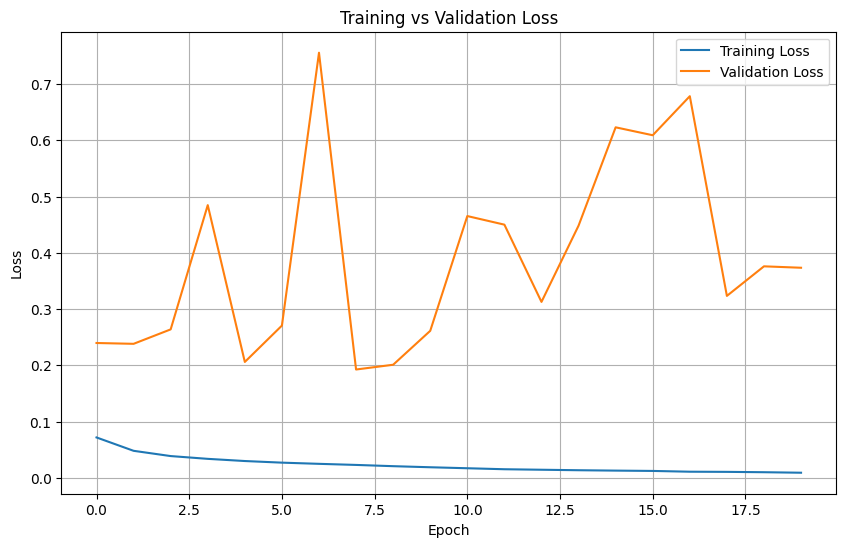

In [15]:
# Start training
train(model, train_loader, val_loader, criterion, optimizer, epochs=20, device=device, checkpoint_path=checkpoint_path)

### Step 14: **Save Final Model**

After training is complete, the model's weights are saved to a file (`model.pth`). This allows us to load the model later for inference or further fine-tuning.

In [16]:
# Save model state
torch.save(model.state_dict(), os.path.join(checkpoint_path, "model.pth"))

### Step 15: **Run Final Evaluation**

After training, we evaluate the model on the test dataset. This includes running the `test`, `compute_roc_auc`, and `compute_iou` functions to assess the model’s classification performance and generalization ability. These evaluations provide insight into how well the model can detect fake images in real-world scenarios.


Classification Report:
              precision    recall  f1-score   support

        Real       0.98      0.97      0.98     19641
        Fake       0.97      0.98      0.98     19787

    accuracy                           0.98     39428
   macro avg       0.98      0.98      0.98     39428
weighted avg       0.98      0.98      0.98     39428



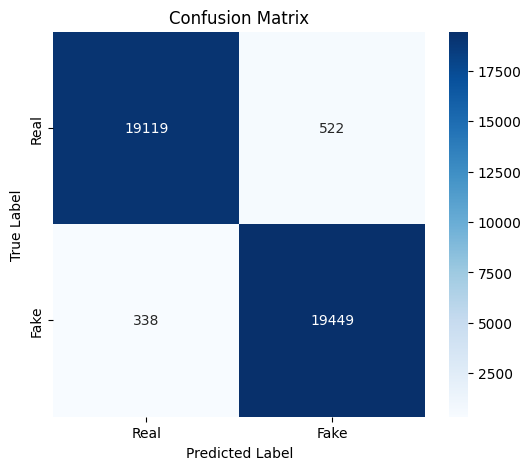

In [17]:
# Run test  
test(model, test_loader)

In [18]:
# Compute and print ROC AUC score
compute_roc_auc(model, test_loader)

ROC AUC Score: 0.9977


In [19]:
# Compute and print IoU score
compute_iou(model, test_loader)

IoU (Jaccard) Score: 0.9577


In [20]:
# Print class-to-index mapping
print(train_dataset.class_to_idx)

{'Fake': 0, 'Real': 1}
